# Capstone 2 - Lending Club Loan Paid or Charged Off Prediction

# Documentation

Documentation is the sixth step in the Data Science Method.  The following will be performed in this step:

1. Review the Results
2. Finalize Code
3. Finalize Documentation
4. Create a Project Report
5. Create a Slide Deck for the Executive Audience

In [1]:
#load python packages
import os
import pandas as pd
import pandas.api.types as ptypes
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings # For handling error messages.
#warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

# Best Model - Logistic Regression

In [2]:
# Read data output created in the EDA step
df = pd.read_csv("../EDA/data/Cap2_step3_output.csv", dtype={'verification_status_joint':object,'hardship_type':object, 'hardship_reason':object, 'hardship_status':object, 'hardship_loan_status':object, 'settlement_status':object}, index_col="Unnamed: 0")
df.head(5)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,initial_list_status,application_type,verification_status_joint,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_loan_status,debt_settlement_flag,settlement_status
0,2500,13.56,55000.0,18.24,0.0,1.0,0.0,45.0,1.0,4341,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
1,30000,18.94,90000.0,26.52,0.0,0.0,71.0,75.0,1.0,12315,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
2,5000,17.97,59280.0,10.51,0.0,0.0,0.0,0.0,0.0,4599,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
3,4000,18.94,92000.0,16.74,0.0,0.0,0.0,0.0,0.0,5468,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN
4,30000,16.14,57250.0,26.35,0.0,0.0,0.0,0.0,0.0,829,...,w,Individual,NaN,N,NaN,NaN,NaN,NaN,N,NaN


In [3]:
df.shape

(2150627, 87)

In [4]:
# Drop unwanted columns
df_sel = df.drop(['title', 'zip_code', 'addr_state'], axis=1)

In [5]:
# Drop irrelevant loan_status

df_sel.reset_index()
df_sel = df_sel[~(df_sel['loan_status'] == 'In Grace Period')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Current')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Late (31-120 days)')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Default')]
df_sel = df_sel[~(df_sel['loan_status'] == 'Late (16-30 days)')]
df_sel.shape

(1250411, 84)

In [6]:
# Loan status:
# Setting '%Fully Paid' to 0
# Setting '%Charges Off' to 1

df_sel['loan_status'] = df_sel['loan_status'].replace(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid'], '0')
df_sel['loan_status'] = df_sel['loan_status'].replace(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'], '1')

In [7]:
df_sel['loan_status'] = pd.to_numeric(df_sel['loan_status'])

In [8]:
# Create a list of object columns.  
cols_obj = []
for col in df_sel.columns:
    if df_sel[col].dtype == object:
        cols_obj.append(col)

In [9]:
df_sel = pd.concat([df_sel.drop(cols_obj, axis=1), pd.get_dummies(df_sel[cols_obj])], axis=1)
df_sel.head(5)

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,hardship_loan_status_Current,hardship_loan_status_In Grace Period,hardship_loan_status_Issued,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days),debt_settlement_flag_N,debt_settlement_flag_Y,settlement_status_ACTIVE,settlement_status_BROKEN,settlement_status_COMPLETE
100,30000,22.35,100000.0,30.46,0.0,0.0,51.0,84.0,1.0,15603,...,0,0,0,0,0,1,0,0,0,0
152,40000,16.14,45000.0,50.53,0.0,0.0,0.0,0.0,0.0,34971,...,0,0,0,0,0,1,0,0,0,0
170,20000,7.56,100000.0,18.92,0.0,0.0,48.0,0.0,0.0,25416,...,0,0,0,0,0,1,0,0,0,0
186,4500,11.31,38500.0,4.64,0.0,0.0,25.0,0.0,0.0,4472,...,0,0,0,0,0,1,0,0,0,0
269,20000,17.97,57000.0,22.18,0.0,0.0,0.0,0.0,0.0,33356,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Using a sample size of 200,000 for modeling, due to Memory error when using all observations.
df_sample = df_sel.sample(200000)
df_sample.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,...,hardship_loan_status_Current,hardship_loan_status_In Grace Period,hardship_loan_status_Issued,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days),debt_settlement_flag_N,debt_settlement_flag_Y,settlement_status_ACTIVE,settlement_status_BROKEN,settlement_status_COMPLETE
976476,7000,9.99,62500.0,4.55,0.0,0.0,0.0,80.0,1.0,1672,...,0,0,0,0,0,1,0,0,0,0
2238060,10000,11.99,47000.0,18.18,0.0,1.0,0.0,89.0,1.0,7472,...,0,0,0,0,0,1,0,0,0,0
783623,14000,5.32,65000.0,28.19,0.0,0.0,0.0,0.0,0.0,14648,...,0,0,0,0,0,1,0,0,0,0
1080906,9000,12.69,40000.0,24.87,1.0,0.0,4.0,0.0,0.0,19387,...,0,0,0,0,0,1,0,0,0,0
1332340,25000,11.99,135000.0,22.89,0.0,3.0,0.0,0.0,0.0,43747,...,0,0,0,0,0,1,0,0,0,0


In [11]:
y = df_sample['loan_status']
X = df_sample.drop(['loan_status'], axis=1)

In [12]:
from sklearn.model_selection import train_test_split

y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [13]:
from sklearn import preprocessing as ppg

scaler = ppg.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_train_scaled

array([[ 0.24124598, -1.08518899, -1.01583076, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [-0.47285305, -0.37895339, -1.24163929, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [-1.5231737 , -0.13440614, -1.75777307, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       ...,
       [-0.47285305, -0.91442755, -0.77389306, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [-0.06224611,  2.47971968,  0.04869515, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [ 0.12222947, -1.68812446,  0.53257056, ..., -0.10491182,
        -0.0586955 , -0.10101015]])

In [14]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 2.14551005, -0.38949422,  1.19386696, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [ 3.09764209,  1.71234726,  1.88742172, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [-0.16936096,  0.83113388, -0.79002224, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       ...,
       [ 1.58613248,  2.03700482,  0.69386236, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [ 1.19337802, -1.14632581,  2.24226369, ..., -0.10491182,
        -0.0586955 , -0.10101015],
       [ 1.41950938,  0.13754728,  0.35837541, ..., -0.10491182,
        -0.0586955 , -0.10101015]])

# Feature importance with Forest of Trees

In [15]:
X_train_scaled.shape

(150000, 153)

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest = forest.fit(X_train_scaled, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_scaled.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 14 (0.167656)
2. feature 15 (0.140086)
3. feature 12 (0.118355)
4. feature 0 (0.050756)
5. feature 13 (0.025588)
6. feature 148 (0.024954)
7. feature 1 (0.022620)
8. feature 149 (0.022300)
9. feature 68 (0.017384)
10. feature 67 (0.016514)
11. feature 65 (0.011684)
12. feature 2 (0.011435)
13. feature 3 (0.011330)
14. feature 9 (0.011049)
15. feature 10 (0.010867)
16. feature 48 (0.010578)
17. feature 33 (0.010406)
18. feature 29 (0.010213)
19. feature 47 (0.009791)
20. feature 22 (0.009698)
21. feature 32 (0.009672)
22. feature 37 (0.009671)
23. feature 44 (0.009526)
24. feature 49 (0.009399)
25. feature 66 (0.008785)
26. feature 152 (0.008737)
27. feature 43 (0.008541)
28. feature 150 (0.008460)
29. feature 5 (0.008355)
30. feature 6 (0.008005)
31. feature 28 (0.007450)
32. feature 69 (0.007380)
33. feature 38 (0.006492)
34. feature 26 (0.006236)
35. feature 17 (0.005950)
36. feature 27 (0.005926)
37. feature 73 (0.005788)
38. feature 21 (0.005573)
39. fea

In [75]:
# Feature selection based on the above feature importance
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(forest, prefit=True, threshold=0.02)
X_train_new = model.transform(X_train_scaled)
X_train_new.shape

(150000, 8)

In [76]:
X_test_new = model.transform(X_test_scaled)
X_test_new.shape

(50000, 8)

In [77]:
model.get_support(True)

array([  0,   1,  12,  13,  14,  15, 148, 149], dtype=int64)

In [78]:
X_cols = X_test.columns

In [79]:
X_cols[0]

'loan_amnt'

In [80]:
X_cols[12]

'total_pymnt'

In [81]:
X_cols[14]

'recoveries'

In [82]:
X_cols[15]

'last_pymnt_amnt'

In [83]:
X_cols[13]

'total_rec_int'

In [98]:
X_cols[148]

'debt_settlement_flag_N'

In [99]:
X_cols[149]

'debt_settlement_flag_Y'

The features selected are:<br>
1. 'loan_amnt' - Loan amount
2. 'total_pymnt' - Payment received to date
3. 'recoveries' - Post charge off gross recovery
4. 'last_pymnt_amnt' - Last total payment amount received
5. 'total_rec_int' - Total received interest
6. 'debt_settlement_flag' - Debt settlement flag

In [84]:
# Using K fold cross validation and Grid search to get the most accurate prediction

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

param_grid = {'C': Cs}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X_train_new, y_train)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))
# Print the accuracy from the testing data.
print("Accuracy score is {}".format(accuracy_score(logreg_cv.predict(X_test_new), y_test)))


Tuned Logistic Regression Parameters: {'C': 100}
Best score is 0.9952866666666667
Accuracy score is 0.99558


# Review the results

In [85]:
from sklearn.metrics import confusion_matrix

y_pred_log = logreg_cv.predict(X_test_new)
pl_log = confusion_matrix(y_test,y_pred_log)
pl_log

array([[39796,    36],
       [  185,  9983]], dtype=int64)

In [86]:
np.bincount(y_pred_log)

array([39981, 10019], dtype=int64)

0 - Fully paid <br>
1 - Charges off

In [87]:
np.bincount(y_test)

array([39832, 10168], dtype=int64)

In [88]:
from sklearn.metrics import classification_report

cl_rep_log = classification_report(y_test,y_pred_log)
print(cl_rep_log)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39832
           1       1.00      0.98      0.99     10168

    accuracy                           1.00     50000
   macro avg       1.00      0.99      0.99     50000
weighted avg       1.00      1.00      1.00     50000



In [89]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

ac = accuracy_score(y_test, y_pred_log)
print('Test Data Set Logistic Regression: Accuracy=%.3f' % (ac))

f1 = f1_score(y_test, y_pred_log, average='weighted')
print('Test Data Set Logistic Regression: f1-score=%.3f' % (f1))

roc_auc = roc_auc_score(y_test, y_pred_log)
print('Test Data Set Logistic Regression: roc_auc_score=%.3f' % (roc_auc))

Test Data Set Logistic Regression: Accuracy=0.996
Test Data Set Logistic Regression: f1-score=0.996
Test Data Set Logistic Regression: roc_auc_score=0.990


# Figures for data story

ROC curve

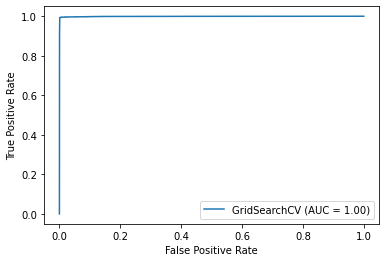

In [90]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(logreg_cv, X_test_new, y_test)

# Finalize code

Save the model

In [91]:
import pickle
s = pickle.dumps(logreg_cv)
from joblib import dump, load
dump(logreg_cv, 'models/model_loan.joblib') 

['models/model_loan.joblib']

# Finalize documentation

In [92]:
logreg_cv.cv_results_

{'mean_fit_time': array([0.26890893, 0.50352526, 0.63174272, 0.81777396, 1.05862679]),
 'std_fit_time': array([0.07177378, 0.03759488, 0.11209398, 0.06126013, 0.09752364]),
 'mean_score_time': array([0.00479579, 0.00400071, 0.00399561, 0.00400043, 0.00400267]),
 'std_score_time': array([1.59788724e-03, 2.52679619e-03, 2.00546167e-05, 8.06122797e-06,
        1.57706997e-05]),
 'param_C': masked_array(data=[0.001, 0.1, 1, 10, 100],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C': 100}],
 'split0_test_score': array([0.95263333, 0.98966667, 0.9935    , 0.9947    , 0.99516667]),
 'split1_test_score': array([0.9474    , 0.9873    , 0.9923    , 0.99413333, 0.99436667]),
 'split2_test_score': array([0.95176667, 0.98993333, 0.9938    , 0.99473333, 0.99506667]),
 'split3_test_score': array([0.94886667, 0.9905    , 0.99443333, 0.99563333, 0.996     ]),
 'split4_test_score': 

In [93]:
logreg_cv.best_params_

{'C': 100}

In [94]:
logreg_cv.best_score_

0.9952866666666667

In [95]:
logreg_cv.best_index_

4

In [96]:
results_df = pd.DataFrame(logreg_cv.cv_results_)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.268909,0.071774,0.004796,0.001598,0.001,{'C': 0.001},0.952633,0.947400,0.951767,0.948867,0.953100,0.950753,0.002230,5
1,0.503525,0.037595,0.004001,0.002527,0.1,{'C': 0.1},0.989667,0.987300,0.989933,0.990500,0.991233,0.989727,0.001327,4
2,0.631743,0.112094,0.003996,0.000020,1,{'C': 1},0.993500,0.992300,0.993800,0.994433,0.994200,0.993647,0.000746,3
3,0.817774,0.061260,0.004000,0.000008,10,{'C': 10},0.994700,0.994133,0.994733,0.995633,0.995500,0.994940,0.000556,2
4,1.058627,0.097524,0.004003,0.000016,100,{'C': 100},0.995167,0.994367,0.995067,0.996000,0.995833,0.995287,0.000586,1


Save model results

In [97]:
results_df.to_csv('models/model_results.csv')